# NLP Class Assignment 3

In [1]:
import nltk.corpus  
from nltk.text import Text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import warnings
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.metrics import jaccard_score
from itertools import combinations
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

## Part 01: News Articles (news_df) Similarity

#### Read news data

In [2]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/nlp_a_3_news.json'
news_df = pd.read_json(news_path, orient='records', lines=True)

print(f'Sample contains {news_df.shape[0]:,.0f} news articles')
news_df.head(2)

Sample contains 1,018 news articles


,url,date,language,title,text
0,https://auto.hindustantimes.com/lml-bikes/dealers/bodh-gaya,2022-01-21,en,Lml Bikes Car Dealers - Lml Bikes Showrooms in India,"Lml Bikes Car Dealers - Lml Bikes Showrooms in India Explore Friday, 21 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCar NewsBik..."
1,https://auto.hindustantimes.com/pure-ev-bikes/dealers/avadi,2022-01-21,en,Pure Ev Bikes Car Dealers - Pure Ev Bikes Showrooms in India,"Pure Ev Bikes Car Dealers - Pure Ev Bikes Showrooms in India Explore Friday, 21 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCar..."


In [4]:
news_df.shape

(1018, 5)

In [5]:
news_df.isna().sum()

url         0
date        0
language    0
title       0
text        0
dtype: int64

In [6]:
# Making sure that there are only english language articles 
news_df['language'].nunique()

1

In [7]:
# Checking median lenght of titles and texts
med_length_title = news_df['title'].apply(lambda x: len(x)).median()
med_length_text = news_df['text'].apply(lambda x: len(x)).median()
print(med_length_title, ',', med_length_text)

67.0 , 4704.5


### The decision to use only the title or text or both to determine if articles are similar depends on the context. 

While it is  possible to use only the titles of the articles to calculate their Jacquard similarity, this approach may not be ideal in many cases. The reason for this is that the title of an article is usually a brief summary of its contents, it may be duplicative, and it may not capture all the important information contained in the text of the article. Using only the titles to calculate the Jacquard similarity between the articles could result in an inaccurate or incomplete measure of their similarity. For example, two articles may have very different titles, but they could still have a significant amount of overlapping content in their main text. Conversely, the articles with very similar titles may actually be quite different in terms of their content and meaning. Also, media agencies use bombastic langauge with a lot of exaggertions in thier titles to capture their audiences' attenion. Therefore, I believe it is better to use text of articles when calculating Jacquard similarity. I did not use text + title beacuse the titles usually appear in the text of articles. 

In [8]:
news_df['text_tokens'] = news_df['text'].apply(lambda x: nltk.tokenize.word_tokenize(x.lower()))

In [9]:
# Remove stopwords from both the columns
stopwords = set(nltk.corpus.stopwords.words('english'))
news_df['text_tokens'] = news_df['text_tokens'].apply(lambda x: [word for word in x if word not in stopwords])

# Remove single-character tokens (mostly punctuation)
news_df['text_tokens'] = news_df['text_tokens'].apply(lambda x: [word for word in x if len(word) > 1])

# Remove punctuation
news_df['text_tokens'] = news_df['text_tokens'].apply(lambda x: [word for word in x if word.isalpha()])
# Remove numbers
news_df['text_tokens']= news_df['text_tokens'].apply(lambda x: [word for word in x if not word.isnumeric()])

In [10]:
# Lemmatizing text
wnl = nltk.WordNetLemmatizer()
news_df['text_tokens'] = news_df['text_tokens'].apply(lambda x: [wnl.lemmatize(word) for word in x])

In [11]:
news_df[['text_tokens']].sample(2, random_state = 42)

,text_tokens
528,"[breaking, electric, picnic, announced, leinster, story, photo, video, send, u, leinster, leader, website, newspaper, please, contact, editorial, team, email, news, leaderhttps, ussponsored, contentepapercontributesearchhomelocal, newsnational, newssportbusinessjobswhats, u, newsadvertise, ussponsored, contentepapercontributecontact, mar, homelocal, newssportnational, newsbusinessjobswhats, onkeep, latest, news, business, event, sport, latest, news, business, event, sport, need, support, ple..."
914,"[safe, flow, dominate, king, dollar, reign, german, zew, expectation, level, skip, main, content, trending, usdcad, trending, usdcad, get, app, newsletter, menu, show, navigation, fxstreet, fxstreet, forex, market, home, rate, chart, live, chart, forecast, poll, rate, table, technical, level, technical, confluence, detector, dollar, index, gold, oil, news, forex, news, institutional, research, dollar, index, commodity, bond, equity, analysis, latest, analysis, dollar, index, oil, gold, stock..."


In [12]:
# Median lenght of text tokens (earlier it was 4704.5)
med_length_text = news_df['text_tokens'].apply(lambda x: len(x)).median()
med_length_text

398.0

#### To choose optimal n, I will calculate average jaccard distance for varying n, and plot n vs average jaccard. The plot will facilitate the choosing of the inflection point which will determine what n to use.

In [13]:
# Choosing a raneg from 4-9 beacuse anything lesser than 4 will result in many similar
for i in range(4, 10):
    news_df[f'{i} grams'] = news_df['text_tokens'].apply(lambda x: set(nltk.ngrams(x, i)))

In [14]:
news_df.head(1)

,url,date,language,title,text,text_tokens,4 grams,5 grams,6 grams,7 grams,8 grams,9 grams
0,https://auto.hindustantimes.com/lml-bikes/dealers/bodh-gaya,2022-01-21,en,Lml Bikes Car Dealers - Lml Bikes Showrooms in India,"Lml Bikes Car Dealers - Lml Bikes Showrooms in India Explore Friday, 21 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCar NewsBik...","[lml, bike, car, dealer, lml, bike, showroom, india, explore, friday, january, log, searchnotificationstop, sectionsauto, newscar, newsbike, newslatestauto, newsphotosvideoselectric, vehiclestrendingmy, readsoffersnewfind, carsfind, bikescompare, carscompare, bikesemi, calculatordealersexplore, autoabout, uscontact, ussitemaprssterms, useprivacy, policycopyright, ht, medium, limited, right, carsfind, bikescompare, carscompare, bikesemi, calculatordealerscar, newsbike, newslatestauto, newspho...","{(bodh, gayasearch, car, dealer), (detail, choose, choose, citychoose), (ussitemaprssterms, useprivacy, policycopyright, ht), (latest, offersadd, comparemaruti, suzuki), (cc, petrol, lakh, onwardscheck), (showroom, indialml, bike, car), (take, continue, session, expired), (vehiclestrendingmy, readsoffersnewfind, carsfind, bikescompare), (clicking, view, offer, agree), (onwardsget, priceadd, comparehelp, u), (offer, agree, term, privacy), (lml, bike, showroom, india), (bikesemi, calculatordea...","{(manual, lakh, onwardscheck, latest, offersadd), (vehiclestrendingmy, read, home, find, car), (session, expired, please, login, continue), (newsphotosvideoselectric, vehiclestrendingmy, readsoffersnewfind, carsfind, bikescompare), (medium, limited, right, carsfind, bikescompare), (cityenter, otpcould, verify, otp, either), (lakh, onwardsget, priceadd, comparemaruti, suzuki), (suzuki, cc, petrol, manual, lakh), (onwardscheck, latest, offersadd, comparerenault, cc), (basic, detail, choose, ch...","{(agree, term, privacy, policyview, offersdear, nameplease), (near, lml, bike, dealer, found, bodh), (dealer, showroom, bodh, gayasearch, car, dealer), (bikesemi, calculatordealerscar, newsbike, newslatestauto, newsphotosvideoselectric, vehiclestrendingmy), (offer, agree, term, privacy, policyview, offersdear), (term, privacy, policyview, offersdear, nameplease, verify), (lakh, onwardsget, priceadd, comparemaruti, suzuki, cc), (onwardscheck, latest, offersadd, comparemaruti, suzuki, vitara),...","{(view, offer, agree, term, privacy, policyview, offersdear), (lml, bike, showroom, india, explore, friday, january), (vitara, cc, petrol, manual, lakh, onwardscheck, latest), (onwardsget, priceadd, comparehelp, u, basic, detail, choose), (cc, petrol, lakh, onwardsget, priceadd, comparehonda, new), (comparerenault, cc, petrol, lakh, onwardscheck, latest, offersadd), (onwardscheck, latest, offersadd, comparehyundai, cc, petrol, manual), (onwardsget, priceadd, comparehonda, new, cc, petrol, ma...","{(priceadd, comparehelp, u, basic, detail, choose, choose, citychoose), (lml, bike, car, dealer, lml, bike, showroom, india), (lakh, onwardsget, priceadd, comparehelp, u, basic, detail, choose), (save, bookmark, take, continue, session, expired, please, login), (newsphotosvideoselectric, vehiclestrendingmy, readsoffersnewfind, carsfind, bikescompare, carscompare, bikesemi, calculatordealersexplore), (comparemaruti, suzuki, cc, petrol, manual, lakh, onwardscheck, latest), (ussitemaprssterms, ...","{(cc, petrol, manual, lakh, onwardsget, priceadd, comparemahindra, cc, petrol), (lakh, onwardscheck, latest, offersadd, comparehyundai, cc, petrol, manual, lakh), (policyview, offersdear, nameplease, verify, mobile, choose, cityenter, otpcould, verify), (comparetata,

In [15]:
# Creating a df with all possible combination of article numbers for comparison
jaccard = pd.DataFrame(list(combinations(range(news_df.shape[0]),2)), columns=['Article A', 'Article B'])

In [17]:
# Computing Jaccard distance for all possble article combinations
cols = list(news_df.columns)[6:]
for col in cols:
    jaccard[f'distance_{col}']= [nltk.jaccard_distance(news_df[col].iloc[x[0]], news_df[col].iloc[x[1]]) for x in n]

posx and posy should be finite values
posx and posy should be finite values


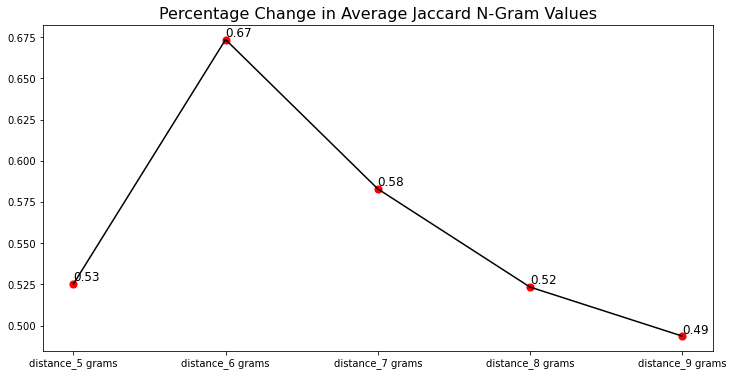

In [18]:
# Plotting a line graph to project percentage change between average jaccard values.  
column_means = jaccard.iloc[:, 2:].mean()
diffs = column_means.diff()
pct_change = (diffs / column_means.shift()) * 100

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=pct_change, color='black')
plt.title('Percentage Change in Average Jaccard N-Gram Values', fontsize=16)
sns.scatterplot(data=pct_change, color='red', marker='o', s=80)

for i, v in enumerate(pct_change):
    ax.text(i, v, str(round(v, 2)), ha='left', va='bottom', fontsize=12)

plt.show()

### The optimal n. 

As mentioned earlier, to choose optimal n, I calculated the average jaccard distances for varying n, and plotted n vs average jaccard. Based on the plot of average Jaccard similarity versus n-gram size, we can see that the percentage change in average Jaccard similarity decreases beyond **n=6**. This suggests that increasing the n-gram size beyond 6 may not significantly increase the capture of Jaccard similarity between the text documents. Therefore, choosing n=6 appears to be the optimal choice for capturing Jaccard similarity in this dataset.

In [34]:
temp = jaccard

In [48]:
# Most similar articles when n = 6
top10 = temp.groupby('distance_6 grams').first().reset_index()[['Article A', 'Article B', 'distance_6 grams']]
top10[['Article A', 'Article B']] = top10[['Article A', 'Article B']].apply(lambda x: news_df.loc[x]['text'].values)

top10.head(10)

,Article A,Article B,distance_6 grams
0,"Toyota Urban Cruiser Car Discount Offers in Kulgam for March 2022 Explore Wednesday, 16 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDeal...","Toyota Urban Cruiser Car Discount Offers in Kandhamal for March 2022 Explore Wednesday, 16 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorD...",0.014322
1,"Toyota Urban Cruiser Car Discount Offers in Kulgam for March 2022 Explore Wednesday, 16 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDeal...","Toyota Urban Cruiser Car Discount Offers in Jajpur Road for March 2022 Explore Wednesday, 16 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculato...",0.015152
2,"Toyota Urban Cruiser Car Discount Offers in Kulgam for March 2022 Explore Wednesday, 16 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDeal...","Toyota Urban Cruiser Car Discount Offers in Khurda Andhra Pradesh for March 2022 Explore Wednesday, 16 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI...",0.015980
3,"Toyota Urban Cruiser Car Discount Offers in Khurda Andhra Pradesh for March 2022 Explore Wednesday, 16 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI...","Toyota Urban Cruiser Car Discount Offers in Jajpur Road for March 2022 Explore Wednesday, 16 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights res

In [52]:
bottom10 = temp.groupby('distance_6 grams').first().reset_index()[['Article A', 'Article B', 'distance_6 grams']]
bottom10 = bottom10.sort_values('distance_6 grams', ascending=False).head(10)
bottom10[['Article A', 'Article B']] = bottom10[['Article A', 'Article B']].apply(lambda x: news_df.loc[x]['text'].values)
bottom10.head(10)

,Article A,Article B,distance_6 grams
6340,"Lml Bikes Car Dealers - Lml Bikes Showrooms in India Explore Friday, 21 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCar NewsBik...","Syncron Price Selected by Mitsubishi Motors Corporation to Boost Enhanced Service Parts Pricing StrategySkip to contentCircle - Country Music & LifestyleAdvertise With UsTeacher TributeAsk The ExpertThank A NurseBe ExcellentWatch LiveNewsElectionsVaccine TrackerVideoWeatherSportsCommunityContestsAbout UsCOVID-19SearchHomeSee it, Snap it, Send itNewsStorm of the CenturyNationalStateEditorialInvestigateEast Texas Ag NewsCrimeEast Texas NowThe Next NormalSept 11thWeatherSign Up for ThunderCallL...",1.000000
6339,Chocolate Is Big Money—But Not for Farmers - BNN BloombergAre you looking for a stock?Try one of these{{result.description}}{{result.ric}}More ResultsBNNAre you looking for a stock?Try one of these{{result.description}}{{result.ric}}More ResultsLiveVideoShowsMarket CallMarketsInvestingPersonal FinanceReal EstateCompany NewsCommoditiesEconomicsPoliticsTechnologyBloomberg News Wire OpinionETFsExecutivePursuitsInternationalMarket CallScheduleListenLiveVideoShowsMarket CallMarketsScoreboardBN...,Live updates: US senators to speak with Ukraine president | National | muscatinejournal.comSkip to main contentSkip to main content××Sign up for our newsletter to keep reading.Be the first to knowGet local news delivered to your inbox!Sign up! Already a Subscriber? Sign inTerms of Service Privacy PolicyBack to homepageSubscriber Login Please subscribe to keep reading. You can cancel at any time. ...,0.999837
6338,"Russia's war spurs corporate exodus, exposes business risks Skip to main content Currently ReadingRussia's war spurs corporate exodus, exposes business risksSubscribeSubscribee-EditionSign In homeAbout UsContact UsAdvertiseSubscribePrivacy NoticeTerms of UseNewsArchivesSpecial SectionsNews TipOnline FormsRSS FeedsSportsSubmit scoresSubmit sports newsPro32NewslettersObituariesSubmit an obituaryFeaturesGamesContestsSpecial SectionsComicsHoroscopesSubmit an AnniversarySubmit BirthSubmit...",Live updates: US senators to speak with Ukraine president | National | muscatinejournal.comSkip to main contentSkip to main content××Sign up for our newsletter to keep reading.Be the first to knowGet local news delivered to your inbox!Sign up! Already a Subscriber? Sign inTerms of Service Privacy PolicyBack to homepageSubscriber Login Please subscribe to keep reading. You can cancel at any time. ...,0.999818
6337,"Zacks: Analysts Expect IQVIA Holdings Inc. (NYSE:IQV) to Announce $2.43 Earnings Per Share - Ticker ReportSkip to main contentAboutContactDisclaimerPrivacy PolicyTerms of Service ☰HomeFinanceAerospace & DefenseEnergyPharmaceuticalsTechnology AboutContactDisclaimerPrivacy PolicyTerms of Service HomeFinanceAerospace & DefenseEnergyPharmaceuticalsTechnology Zacks: Analysts Expect IQVIA Holdings Inc. (NYSE:IQV) to Announce $2.43 Earnings Per SharePosted by Max Byerly on Feb 17th, 2022Share on ...","Live updates: As many as 15,000 Russians killed in fighting | MarketBeatSkip to main contentS&P 500 4,492.66 (-0.42%) DOW 34,541.20 (-0.76%) QQQ 356.29 (-0.19%) AAPL 170.91 (+1.24%) MSFT 301.58 (-0.82%) FB 215.95 (-0.32%) GOOGL 2,784.32 (-0.47%) AMZN 3,268.00 (-0.90%) TSLA 999.00 (+0.51%) NVDA 263.10 (-0.81%) BABA 123.16 (+7.10%) NIO 22.44 (+3.08%) AMD 113.06 (-1.50%) MU 76.77 (-2.97%) GE 93.96 (-0.99%) T 23.29 (+0.34%) F 16.89 (-1.17%) DIS ...",0.999757
6336,"Live updates: As many as 15,000 Russians killed in fighting | MarketBeatSkip to main contentS&P 500 4,492.66 (-0.42%) DOW 34,541.20 (-0.76%) QQQ 356.

## Part 02: Tweet (tweets_df) Similarity

#### Read Tweets data

In [145]:
tweets_path = 'https://storage.googleapis.com/msca-bdp-data-open/tweets/nlp_a_3_tweets.json'
tweets_df = pd.read_json(tweets_path, orient='records', lines=True)
print(f'Sample contains {tweets_df.shape[0]:,.0f} tweets')
tweets_df.head(2)

Sample contains 1,020 tweets


,id,lang,date,name,retweeted,text
0,1491880241782005777,en,2022-02-10,Sir Botalot dropping the Mike!,,@singervehicles Will you do a straight swap for my Renault Twingo 1.2 Extreme? \n\nThat is awesome! 🔥
1,1501237946590142469,en,2022-03-08,Sabrina Ghio,RT,"Australian GP Qualifying, Melbourne, 8th March 1997. #F1 The Grid ⬇️\n\nRow 3:\n5. Eddie Irvine (Ferrari) +2.512s\n6. Mika Hakkinen (McLaren-Mercedes) +2.602s\n\nRow 4:\n7. Johnny Herbert (Sauber-Petronas) +2.918s\n8. Jean Alesi (Benetton-Renault) +3.224s https://t.co/i4IC4LzVVN"


In [146]:
tweets_df.shape

(1020, 6)

In [147]:
tweets_df.isna().sum()

id           0
lang         0
date         0
name         0
retweeted    0
text         0
dtype: int64

In [148]:
# Making sure that there are only english language tweets 
tweets_df['lang'].nunique()

1

In [149]:
# Checking median lenght of tweet texts
med_length_text = tweets_df['text'].apply(lambda x: len(x)).median()
med_length_text

179.0

In [150]:
# Use TweetTokenizer and lower case all words
tweet_tokenizer = nltk.tokenize.TweetTokenizer()
tweets_df['text_tokens'] = tweets_df['text'].apply(lambda x: tweet_tokenizer.tokenize(x))

# Remove stopwords
tweets_df['text_tokens'] = tweets_df['text_tokens'].apply(lambda x: [word for word in x if word not in stopwords])

# Remove single-character tokens (mostly punctuation)
tweets_df['text_tokens'] = tweets_df['text_tokens'].apply(lambda x: [word for word in x if len(word) > 1])

# Remove numbers
tweets_df['text_tokens'] = tweets_df['text_tokens'].apply(lambda x: [word for word in x if not word.isnumeric()])

# Remove punctuation
tweets_df['text_tokens'] = tweets_df['text_tokens'].apply(lambda x: [word for word in x if word.isalpha()])

In [151]:
tweets_df['text_tokens'] = tweets_df['text_tokens'].apply(lambda x: [wnl.lemmatize(word) for word in x])

In [152]:
tweets_df.sample(3, random_state = 42)

,id,lang,date,name,retweeted,text,text_tokens
523,1506844523829280770,en,2022-03-24,Missy1275*,RT,Renault industrial activities in Russia are suspended The Board of Directors of Renault Group met today and approved the following items: - @RenaultGroup activities in its manufacturing plant in Moscow are suspended as of today. https://t.co/I5036FK7UE,"[Renault, industrial, activity, Russia, suspended, The, Board, Directors, Renault, Group, met, today, approved, following, item, activity, manufacturing, plant, Moscow, suspended, today]"
602,1506228835536314374,en,2022-03-22,Viktorija Semjonova,RT,"Incredible but the French carmaker Renault has resumed manufacturing in its plants in Moscow, bucking the trend of many other large global companies that have cut ties with Russia over its war on #Ukraine.\n https://t.co/AQpZB3hVsy","[Incredible, French, carmaker, Renault, resumed, manufacturing, plant, Moscow, bucking, trend, many, large, global, company, cut, tie, Russia, war]"
526,1507021474762211331,en,2022-03-24,ДревляниН,RT,Carmaker Renault said it would suspend operations at its plant in Moscow. The move comes as pressure mounts over the French company's continued presence in Russia since the country's invasion of Ukraine https://t.co/FFSwwtQnDO,"[Carmaker, Renault, said, would, suspend, operation, plant, Moscow, The, move, come, pressure, mount, French, continued, presence, Russia, since, invasion, Ukraine]"


In [153]:
# Checking median lenght of tweet texts
med_length_text = tweets_df['text_tokens'].apply(lambda x: len(x)).median()
med_length_text

14.0

#### To choose optimal n, I will calculate average jaccard distance for varying n, and plot n vs average jaccard. The plot will facilitate the choosing of the inflection point which will determine what n to use.

In [154]:
# Choosing a raneg from 1-4 beacuse anything more than 3 will result in no similar reults 
for i in range(1, 5):
    tweets_df[f'{i} grams'] = tweets_df['text_tokens'].apply(lambda x: set(nltk.ngrams(x, i)))

tweets_df.head(1)

,id,lang,date,name,retweeted,text,text_tokens,1 grams,2 grams,3 grams,4 grams
0,1491880241782005777,en,2022-02-10,Sir Botalot dropping the Mike!,,@singervehicles Will you do a straight swap for my Renault Twingo 1.2 Extreme? \n\nThat is awesome! 🔥,"[Will, straight, swap, Renault, Twingo, Extreme, That, awesome]","{(Will,), (That,), (straight,), (Twingo,), (swap,), (awesome,), (Extreme,), (Renault,)}","{(Will, straight), (straight, swap), (swap, Renault), (That, awesome), (Twingo, Extreme), (Renault, Twingo), (Extreme, That)}","{(Renault, Twingo, Extreme), (Extreme, That, awesome), (straight, swap, Renault), (Will, straight, swap), (Twingo, Extreme, That), (swap, Renault, Twingo)}","{(Renault, Twingo, Extreme, That), (straight, swap, Renault, Twingo), (swap, Renault, Twingo, Extreme), (Will, straight, swap, Renault), (Twingo, Extreme, That, awesome)}"


In [155]:
# Creating a df with all possible combination of tweets numbers for comparison
jaccard = pd.DataFrame(list(combinations(range(tweets_df.shape[0]),2)), columns=['Tweet A', 'Tweet B'])

In [156]:
n = list(combinations(range(tweets_df.shape[0]),2))

In [157]:
# Computing Jaccard distance for all possble tweets combinations
cols = list(tweets_df.columns)[7:]
for col in cols:
    jaccard[f'distance_{col}'] = [nltk.jaccard_distance(tweets_df[col].iloc[x[0]], tweets_df[col].iloc[x[1]]) if tweets_df[col].iloc[x[0]].union(tweets_df[col].iloc[x[1]]) else 0 for x in n]

posx and posy should be finite values
posx and posy should be finite values


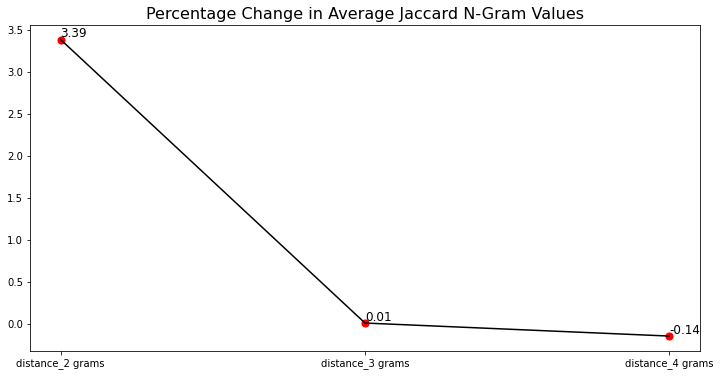

In [158]:
# Plotting a line graph to project percentage change between average jaccard values.  
column_means = jaccard.iloc[:, 2:].mean()
diffs = column_means.diff()
pct_change = (diffs / column_means.shift()) * 100

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=pct_change, color='black')
plt.title('Percentage Change in Average Jaccard N-Gram Values', fontsize=16)
sns.scatterplot(data=pct_change, color='red', marker='o', s=80)

for i, v in enumerate(pct_change):
    ax.text(i, v, str(round(v, 2)), ha='left', va='bottom', fontsize=12)

plt.show()

### The optimal n. 

As mentioned earlier, to choose optimal n, I calculated the average jaccard distances for varying n, and plotted n vs average jaccard. Based on the plot of average Jaccard similarity versus n-gram size, we can see that the percentage change in average Jaccard similarity decreases beyond **n=2**. This suggests that increasing the n-gram size beyond 2 may not significantly increase the capture of Jaccard similarity between the text documents. Therefore, choosing n=2 appears to be the optimal choice for capturing Jaccard similarity in this dataset.

In [160]:
temp = jaccard

In [161]:
# Most similar articles when n = 2
top10 = temp.groupby('distance_2 grams').first().reset_index()[['Tweet A', 'Tweet B', 'distance_2 grams']]
top10[['Tweet A', 'Tweet B']] = top10[['Tweet A', 'Tweet B']].apply(lambda x: news_df.loc[x]['text'].values)

top10.head(10)

,Tweet A,Tweet B,distance_2 grams
0,Mahindra Teases Its Future Electric Lineup! | Motoroids Motoroids BlogMotoroids Forum AuthorsContact usSubmit storyAdvertise with usPrivacy Policy Search HomeAuto NewsFeaturesLaunchesUpcoming CarsUpcoming SUVsUpcoming BikesRecent LaunchesReviewsModsModified BikesModified CarsInteresting / Off-beatLists100cc Bikes110cc Bikes125cc Bikes150cc Bikes160cc Bikes200cc Bikes250cc Bikes300cc – 350cc BikesBikes In IndiaCars in IndiaForums Trending: Triumph Trident 660 Gets Pricier! HomeNewsMahindra Te...,"Mahindra Bikes Car Dealers - Mahindra Bikes Showrooms in India Explore Friday, 7 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCa...",0.000000
1,"Connected car apps stealing your data without consent, warn expertsContribute VideosSearchE paperContributeLoginHomeNewsNationalInternationalIndiaBusinessSportsSci technologyInterviewsDemonetisationDemocracyInstitutionGovernanceOpinionEditorialVoicesDissentInvestigationCorruptionCrimePoliticsArchivesCafeReviews & RecommendationsPeopleBook ExtractsFilmsArtEntertainmentYoung IndiaCampusEducationVideosEYE ON RSSSubscribe NewspaperContribute VideosSearchFollow UsE paperContributeLoginScience and...",Me & My Car: Jeremy Corbett and his 7 Days a week SUV - ME & MY CAR - DrivenCars For SaleNewsNewsVideosZooming with DRIVENEV/HybridMotorsportClean Car CalculatorReviewsReviewsLong-term testAdviceAdviceBuying & Selling TipsCar Maintenance TipsFinance & InsuranceCar Value CalculatorHow it worksHow it worksWho we areLoginLoginORRegisterCloseLoginWelcome to DrivenRemember meLoginForgot your password?Not registered yet?Login with social media Login with Facebook Login with Google CloseKeep up to...,0.095238
2,Volkswagen picks San Diego's Qualcomm to supply chips for autonomous driving efforts - The San Diego Union-Tribune News Local Sports Business Entertainment Lifestyle Opinion Real Estate News Hot Property eNewspaper U-T En Español: Periódico Electrónico ________________ Subscriptions Manage Subscription EZPay Delivery Issue eNewspaper Subscribe Subscriber Terms Gift Subscription Terms Manage Subscription EZPay Del...,"Brazilians arrested with cocaine in Thailand; Family of young woman asks for help to avoid execution - Brazil About Us Our Team Privacy Policy DMCA Policy Contact Us Play Crazy Game Trusted Gaming News Portal News Games PC PS4 Xbox One Switch Entertainment Celebrity News Technology Breaking News Leaks image of SUV at factory in Italy Queen Elizabeth II tests positive for Covid-19, confirms Buckingham Palace | coronavirus pandemic Who is Vladimir Putin, the...",0.100000
3,Bay Street Seen Opening Higher ▮ Home ▮ Business Latest HeadlinesTop StoriesBreaking NewsEarningsBiotechInvestorsStock AlertsIPOsM&ACanadianUKKey Wallstreet Events▮ Industry News Technology Software Banking Automotive EnergyMore▮ Corp. CalendarsDividendsStock ...,Toyota Sales Figures - May 2022 HOME CAR NEWS Alfa Romeo Audi Bentley BMW Bugatti Chevrolet Citroen Dacia Daihatsu Datsun DC Design Ferrari Fiat Ford Honda Hyundai Infiniti Isuzu Jaguar Jeep Kia Lada Lamborghini Land Rover Lexus Mahindra Maruti Suzuki Maserati Mazda McLaren Mercedes-Benz Mini Mitsubishi Nissan Opel Perodua Peugeot Porsche Proton Renault Rolls Royce Skoda Ssangyong Suzuki Tata Tesla Toyota Volkswagen Volvo MG BIKE NEWS Apri...,0.230769
4,"Lamborghini Huracan Sto Car Discount Offers in Orai for March 2022 Explore Tuesday, 15 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbou

In [162]:
bottom10 = temp.groupby('distance_2 grams').first().reset_index()[['Tweet A', 'Tweet B', 'distance_2 grams']]
bottom10 = bottom10.sort_values('distance_2 grams', ascending=False).head(10)
bottom10[['Tweet A', 'Tweet B']] = bottom10[['Tweet A', 'Tweet B']].apply(lambda x: news_df.loc[x]['text'].values)
bottom10.head(10)

,Tweet A,Tweet B,distance_2 grams
124,"Lml Bikes Car Dealers - Lml Bikes Showrooms in India Explore Friday, 21 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCar NewsBik...","Pure Ev Bikes Car Dealers - Pure Ev Bikes Showrooms in India Explore Friday, 21 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCar...",1.000000
123,"Bugatti Car Dealers - Bugatti Showrooms in India Explore Friday, 21 January 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersCar NewsBike Ne...","Big Alfa Romeo crossover is going to save Alfa! - Pledge Times About UsDisclaimer for Pledge TimesT & CWrite To Us Sunday, July 31, 2022 Pledge Times WorldBusinessGamingTechEntertainmentScienceLifestyleHealthSports WorldBusinessGamingTechEntertainmentScienceLifestyleHealthSports No Result View All Result Pledge Times No Result View All Result HomeWorld Europe Big Alfa Romeo crossover is going to save Alfa!byadmin_l6ma5gus July 31, 2022inW...",0.981818
122,"Porsche Cayenne Coupe Car Discount Offers in Giridih for March 2022 Explore Wednesday, 16 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDe...","Audi A8 L Car Discount Offers in Akbarpur (Rajasthan) for March 2022 Explore Sunday, 13 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDeal...",0.981481
121,"Mahindra Bolero Neo Car Discount Offers in West Godavari for March 2022 Explore Tuesday, 15 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculator...","Toyota Urban Cruiser Car Discount Offers in Ghogha for March 2022 Explore Wednesday, 16 March 2022 Log in/Sign up SearchNotificationsTop SectionsAuto NewsCar NewsBike NewsLatestAuto NewsPhotosVideosElectric VehiclesTrendingMy ReadsOffersnewFind carsFind bikesCompare carsCompare bikesEMI calculatorDealersExplore AutoAbout UsContact UsSITEMAPRSSTerms of UsePrivacy PolicyCopyright © HT Media Limited All rights reserved.HomeOffersnewFind carsFind bikesCompare carsComp

### Was the “n” identical or different for articles vs. tweets and why?

In the case of comparing the n value of articles to tweets, the n value needed to be larger for the articles dataset. This is because the median length of the article text was considerably larger than that of a tweet, meaning that a larger n was required to capture a greater number of Jaccard similarities between the articles and tweets.

If we had used the titles of the articles instead of the full text, we might have been able to achieve a similar n value. This is because article titles are generally shorter and more concise, which means that a smaller n value might be sufficient to capture a comparable number of similarities. Ultimately, the choice of n value depends on the length of the text and how much context capturing is deemed necessary.